# Visualization

In [1]:
import os
import sys
import math

sys.path.append('../')
from time import time
import numpy as np
import pylab as plt

import torch
import torch.nn as nn

from sklearn import datasets
from pathlib import Path
from metrics.ood import entropy_fn


seed = 42
np.random.seed(seed)
torch.manual_seed(42)
plot_path = Path('plots/2D/')
os.makedirs(plot_path, exist_ok=True)

levels = {
    "sngp": np.linspace(0, 0.15, 16),
    "sngp_sampling": np.linspace(0, 0.17, 16),
    "mc_dropout": np.linspace(0, 0.45, 16),
    "ensemble": np.linspace(0, 0.45, 16),
}
figsize= (7, 7)

In [16]:
@torch.no_grad()
def plot_contour(model, X, y, ax=None, levels=100, method="cat_entropy"):
    if ax:
        plt.sca(ax)
    domain = 5
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51))
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    probas = model.forward_mean_field(zz).softmax(-1)
    if method == "cat_entropy":
        score = entropy_fn(probas)
    elif method == "dir_alpha_sum":
        alphas = model.forward_dirichlet(zz)
        score = -alphas.sum(-1)
    elif method == "dir_variance":
        alphas = model.forward_dirichlet(zz)
        dist = torch.distributions.Dirichlet(alphas)
        score = dist.variance.sum(-1)

    zz = score.view(xx.shape)
    pp = probas[:, 1].view(xx.shape)

    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap="bwr")
    plt.contour(xx, yy, pp, levels=[0.3, 0.5, 0.7], colors=["b", "k", "r"])
    plt.contourf(xx, yy, zz, alpha=0.75, zorder=-1, levels=levels, cmap="Purples_r")
    plt.colorbar()


@torch.no_grad()
def plot_contour_sampling(model, X, y, ax=None, levels=100, weights=None, method="cat_entropy"):
    if ax:
        plt.sca(ax)
    domain = 5
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51))
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)
    contour_ds = torch.utils.data.TensorDataset(zz, torch.ones(len(zz)))
    contour_loader = torch.utils.data.DataLoader(
        contour_ds, batch_size=32, shuffle=False
    )
    logits = []
    for z_batch, _ in contour_loader:
        logits.append(model.forward_sample(z_batch))
    logits = torch.cat(logits, dim=1)
    probas_raw = logits.softmax(-1)
    if weights is not None:
        probas = torch.einsum('e,enk->nk', weights, probas_raw)
        variance = torch.einsum('e,enk->nk', weights, (probas_raw - probas[None]) ** 2)
    else:
        probas = probas_raw.mean(0)
        variance = ((probas_raw - probas[None]) ** 2).mean(0)
    variance = variance.sum(-1)
    print(variance.min())

    if method == "cat_entropy":
        score = entropy_fn(probas)
    elif method == "dir_variance":
        score = variance

    zz = score.view(xx.shape)
    pp = probas[:, 1].view(xx.shape)

    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap="bwr")
    plt.contour(xx, yy, pp, levels=[0.3, 0.5, 0.7], colors=["b", "k", "r"])
    plt.contourf(xx, yy, zz, alpha=0.75, zorder=-1, levels=levels, cmap="Purples_r")
    #plt.colorbar()

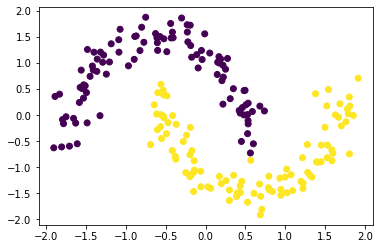

In [17]:
X, y = datasets.make_moons(200, noise=.1)
n_classes = len(np.unique(y))
X = (X - X.mean(0)) / X.std(0)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()


train_ds = torch.utils.data.TensorDataset(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

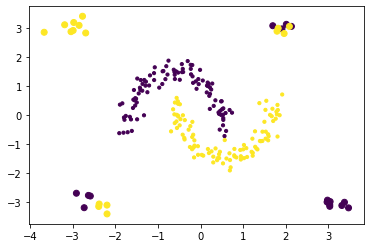

In [18]:
n_samples_new = 8
torch.manual_seed(1)

# Create new Cluster
noise = .2
X_new = torch.cat([
    torch.randn((int(n_samples_new/2), 2))*noise - torch.Tensor([-2, -3]),
    torch.randn((int(n_samples_new/2), 2))*noise - torch.Tensor([-2, -3]),
    torch.randn((n_samples_new, 2))*noise - torch.Tensor([-3, 3]),
    torch.randn((n_samples_new, 2))*noise - torch.Tensor([3, -3]),
    torch.randn((int(n_samples_new/2), 2))*noise - torch.Tensor([2.75, 2.75]),
    torch.randn((int(n_samples_new/2), 2))*noise - torch.Tensor([2.25, 3.25]),
])
y_new = torch.cat([
    torch.ones(int(n_samples_new/2)).long()*0,
    torch.ones(int(n_samples_new/2)).long()*1,
    torch.ones(n_samples_new).long()*0,
    torch.ones(n_samples_new).long()*1,
    torch.ones(int(n_samples_new/2)).long()*0,
    torch.ones(int(n_samples_new/2)).long()*1,
])
reweight_ds = torch.utils.data.TensorDataset(X_new, y_new)
reweight_loader = torch.utils.data.DataLoader(
    reweight_ds, batch_size=128, shuffle=True
)
X_ext = torch.cat((X, X_new))
y_ext = torch.cat((y, y_new))
extend_ds = torch.utils.data.TensorDataset(X_ext, y_ext)
extended_loader = torch.utils.data.DataLoader(
    extend_ds, batch_size=128, shuffle=True
)

plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new)
plt.scatter(X[:, 0], X[:, 1], c=y, s=10)
plt.show()

## SNGP

Epoch [0] [0/2] eta: 0:00:00 lr: 0.001 loss: 0.6865 (0.6865) acc1: 50.0000 (50.0000) time: 0.0105 data: 0.0016
Epoch [0] Total time: 0:00:00
Epoch [1] [0/2] eta: 0:00:00 lr: 0.001 loss: 0.6200 (0.6200) acc1: 96.0938 (96.0938) time: 0.0094 data: 0.0013
Epoch [1] Total time: 0:00:00
Epoch [2] [0/2] eta: 0:00:00 lr: 0.001 loss: 0.5908 (0.5908) acc1: 98.4375 (98.4375) time: 0.0097 data: 0.0014
Epoch [2] Total time: 0:00:00
Epoch [3] [0/2] eta: 0:00:00 lr: 0.001 loss: 0.5672 (0.5672) acc1: 98.4375 (98.4375) time: 0.0139 data: 0.0021
Epoch [3] Total time: 0:00:00
Epoch [4] [0/2] eta: 0:00:00 lr: 0.001 loss: 0.5468 (0.5468) acc1: 97.6562 (97.6562) time: 0.0104 data: 0.0014
Epoch [4] Total time: 0:00:00
Epoch [5] [0/2] eta: 0:00:00 lr: 0.001 loss: 0.5318 (0.5318) acc1: 99.2188 (99.2188) time: 0.0158 data: 0.0022
Epoch [5] Total time: 0:00:00
Epoch [6] [0/2] eta: 0:00:00 lr: 0.001 loss: 0.5126 (0.5126) acc1: 98.4375 (98.4375) time: 0.0101 data: 0.0014
Epoch [6] Total time: 0:00:00
Epoch [7] [0/

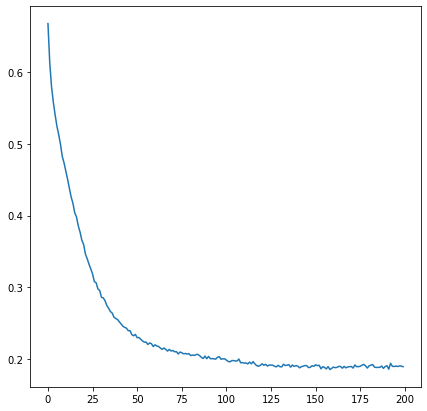

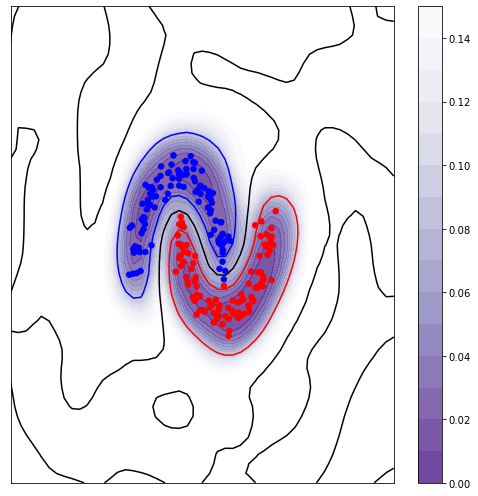

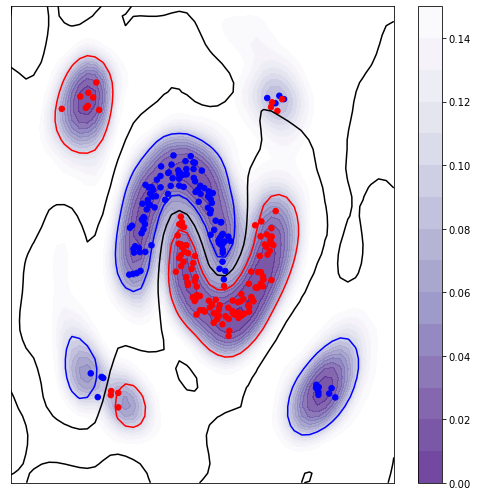

tensor(0.0149)


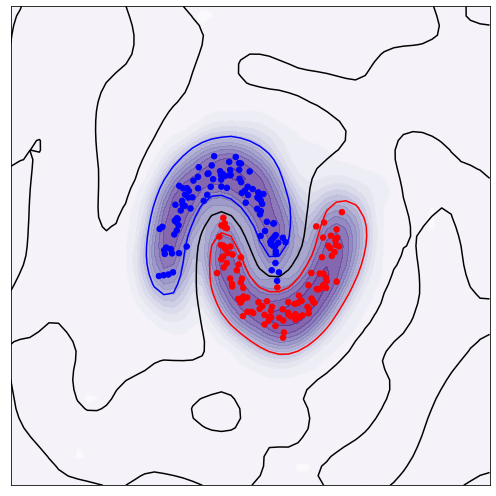

tensor(0.0122)


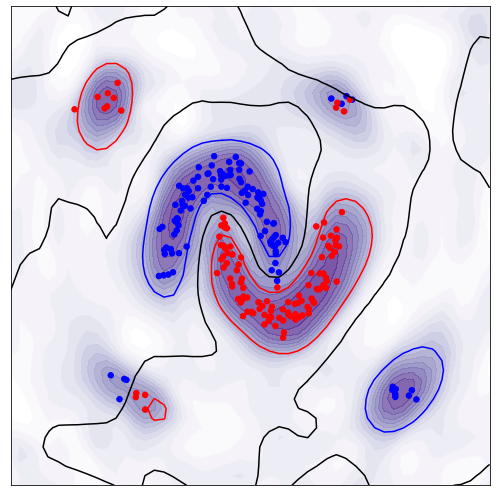

Epoch [0] [0/2] eta: 0:00:00 lr: 0.001 loss: 0.6827 (0.6827) acc1: 55.4688 (55.4688) time: 0.0098 data: 0.0011
Epoch [0] Total time: 0:00:00
Epoch [1] [0/2] eta: 0:00:00 lr: 0.001 loss: 0.6299 (0.6299) acc1: 92.9688 (92.9688) time: 0.0135 data: 0.0024
Epoch [1] Total time: 0:00:00
Epoch [2] [0/2] eta: 0:00:00 lr: 0.001 loss: 0.6019 (0.6019) acc1: 96.8750 (96.8750) time: 0.0266 data: 0.0021
Epoch [2] Total time: 0:00:00
Epoch [3] [0/2] eta: 0:00:00 lr: 0.001 loss: 0.5764 (0.5764) acc1: 97.6562 (97.6562) time: 0.0140 data: 0.0022
Epoch [3] Total time: 0:00:00
Epoch [4] [0/2] eta: 0:00:00 lr: 0.001 loss: 0.5545 (0.5545) acc1: 98.4375 (98.4375) time: 0.0149 data: 0.0021
Epoch [4] Total time: 0:00:00
Epoch [5] [0/2] eta: 0:00:00 lr: 0.001 loss: 0.5465 (0.5465) acc1: 96.8750 (96.8750) time: 0.0244 data: 0.0018
Epoch [5] Total time: 0:00:00
Epoch [6] [0/2] eta: 0:00:00 lr: 0.001 loss: 0.5390 (0.5390) acc1: 98.4375 (98.4375) time: 0.0106 data: 0.0012
Epoch [6] Total time: 0:00:00
Epoch [7] [0/

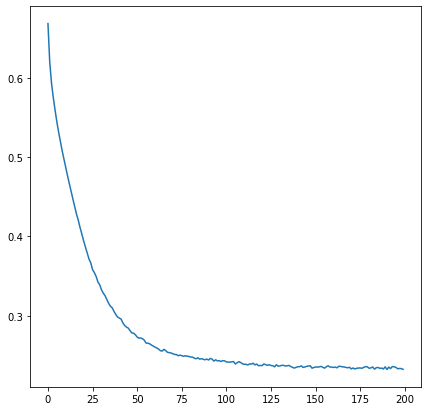

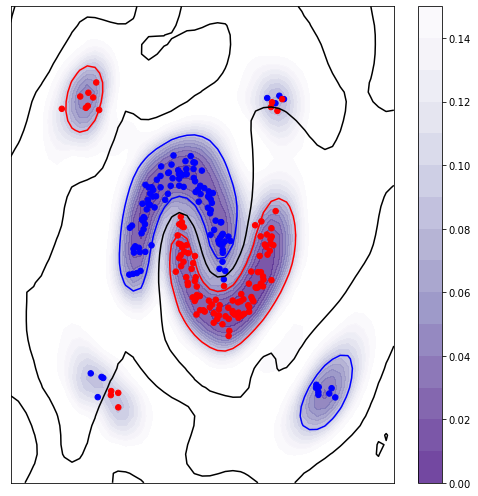

tensor(0.0151)


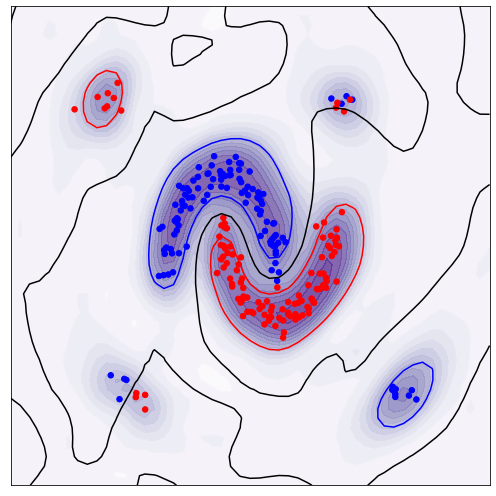

In [19]:
from model import sngp
from model import SpectralTabularResNet

# Training hparams
epochs = 200
weight_decay = 5e-2
net_hparams = dict(
    norm_bound=1,
    n_residual_layers=2,
    spectral_norm=True,
    in_features=2
)

kernel_scale = 2
gp_hparams = dict(
    num_inducing=1024,
    kernel_scale=kernel_scale,             # works like bandwidth
    normalize_input=False,      # important to disable
    scale_random_features=True,  # important to enable
    # Not that important, for inference
    cov_momentum=-1,
    ridge_penalty=1,
    mean_field_factor=math.pi/8,
)
method = "dir_variance"

for mode, ds in enumerate([train_ds, extend_ds]):
    torch.manual_seed(0)
    name = "" if mode == 0 else "_retrained"
    X_plot, y_plot = (X, y) if mode == 0 else (X_ext, y_ext)

    # Init model
    train_loader = torch.utils.data.DataLoader(ds, batch_size=128, shuffle=True)
    backbone = SpectralTabularResNet(num_classes=n_classes, **net_hparams)
    model_sngp = sngp.SNGP(model=backbone, in_features=128, num_classes=n_classes, **gp_hparams)
    nn.init.normal_(model_sngp.random_features.random_feature_linear.weight)
    nn.init.xavier_normal_(model_sngp.beta.weight)
    optimizer = torch.optim.Adam(model_sngp.parameters(), lr=1e-3, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    # Train
    history = []
    for i in range(epochs):
        train_stats = sngp.train_one_epoch(model_sngp, train_loader, criterion, optimizer, device='cpu', epoch=i)
        history.append(train_stats)
    model_sngp.cpu()
    model_sngp.eval()

    plt.figure(figsize=figsize)
    plt.plot([d['train_loss'] for d in history])
    plt.show()

    # Plot sngp-la and sngp-mc
    for addendum in ["", "_sampling"]:
        fig = plt.figure(figsize=figsize)
        if addendum == "":
            plot_contour(model_sngp, X_plot, y_plot, method=method, levels=levels["sngp"])
        else:
            model_sngp.sample_betas(20000)
            plot_contour_sampling(model_sngp, X_plot, y_plot, method=method, levels=levels["sngp"])
        fig.axes[0].get_xaxis().set_visible(False)
        fig.axes[0].get_yaxis().set_visible(False)
        fig.axes[0].get_xaxis().set_ticks([])
        fig.axes[0].get_yaxis().set_ticks([])
        plt.tight_layout()
        plt.savefig(plot_path/f'sngp{addendum}_2d{name}.pdf', bbox_inches='tight')
        plt.show()
        if mode == 0:
            fig = plt.figure(figsize=figsize)
            if addendum == "":
                reweighted_model_sngp = sngp.reweight(model_sngp, dataloader=reweight_loader, device='cpu')
                plot_contour(reweighted_model_sngp, X_ext, y_ext, method=method, levels=levels["sngp"])
            else:
                weights = sngp.reweight_sampling(model_sngp, reweight_loader, device='cpu', n_draws=20000)
                plot_contour_sampling(model_sngp, X_ext, y_ext, weights=weights, method=method, levels=levels["sngp"])
            fig.axes[0].get_xaxis().set_visible(False)
            fig.axes[0].get_yaxis().set_visible(False)
            fig.axes[0].get_xaxis().set_ticks([])
            fig.axes[0].get_yaxis().set_ticks([])
            plt.tight_layout()
            plt.savefig(plot_path/f'sngp{addendum}_2d_reweighted.pdf', bbox_inches='tight')
            plt.show()

## MC-Dropout

Epoch [0] [0/2] eta: 0:00:00 lr: 0.001 loss: 0.6900 (0.6900) acc1: 54.6875 (54.6875) time: 0.0064 data: 0.0022
Epoch [0] Total time: 0:00:00
Epoch [1] [0/2] eta: 0:00:00 lr: 0.001 loss: 0.5382 (0.5382) acc1: 74.2188 (74.2188) time: 0.0061 data: 0.0016
Epoch [1] Total time: 0:00:00
Epoch [2] [0/2] eta: 0:00:00 lr: 0.001 loss: 0.4060 (0.4060) acc1: 89.0625 (89.0625) time: 0.0078 data: 0.0024
Epoch [2] Total time: 0:00:00
Epoch [3] [0/2] eta: 0:00:00 lr: 0.001 loss: 0.3933 (0.3933) acc1: 80.4688 (80.4688) time: 0.0115 data: 0.0018
Epoch [3] Total time: 0:00:00
Epoch [4] [0/2] eta: 0:00:00 lr: 0.001 loss: 0.3317 (0.3317) acc1: 85.9375 (85.9375) time: 0.0059 data: 0.0021
Epoch [4] Total time: 0:00:00
Epoch [5] [0/2] eta: 0:00:00 lr: 0.001 loss: 0.3410 (0.3410) acc1: 82.8125 (82.8125) time: 0.0047 data: 0.0013
Epoch [5] Total time: 0:00:00
Epoch [6] [0/2] eta: 0:00:00 lr: 0.001 loss: 0.2656 (0.2656) acc1: 86.7188 (86.7188) time: 0.0046 data: 0.0013
Epoch [6] Total time: 0:00:00
Epoch [7] [0/

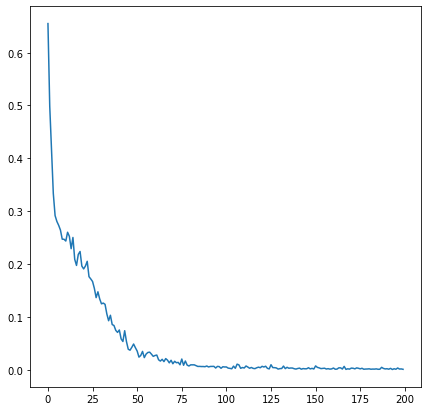

tensor(0.)


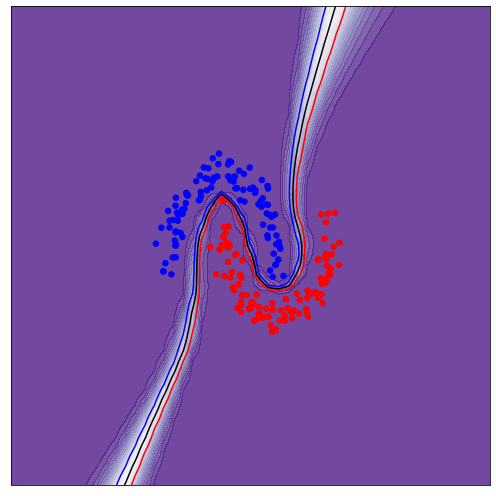

tensor(0.)


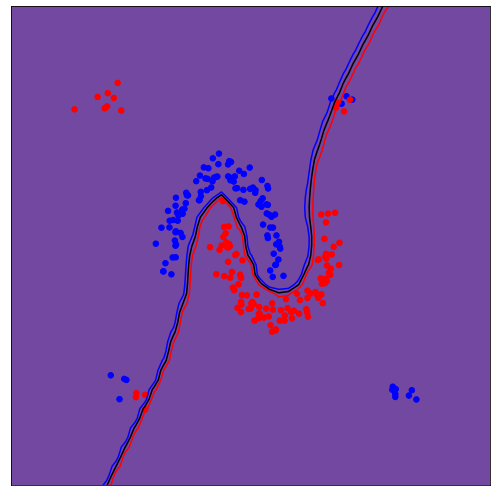

Epoch [0] [0/2] eta: 0:00:00 lr: 0.001 loss: 0.7576 (0.7576) acc1: 51.5625 (51.5625) time: 0.0035 data: 0.0007
Epoch [0] Total time: 0:00:00
Epoch [1] [0/2] eta: 0:00:00 lr: 0.001 loss: 0.6373 (0.6373) acc1: 68.7500 (68.7500) time: 0.0028 data: 0.0007
Epoch [1] Total time: 0:00:00
Epoch [2] [0/2] eta: 0:00:00 lr: 0.001 loss: 0.6465 (0.6465) acc1: 71.8750 (71.8750) time: 0.0028 data: 0.0008
Epoch [2] Total time: 0:00:00
Epoch [3] [0/2] eta: 0:00:00 lr: 0.001 loss: 0.5926 (0.5926) acc1: 75.7812 (75.7812) time: 0.0031 data: 0.0007
Epoch [3] Total time: 0:00:00
Epoch [4] [0/2] eta: 0:00:00 lr: 0.001 loss: 0.5767 (0.5767) acc1: 77.3438 (77.3438) time: 0.0034 data: 0.0010
Epoch [4] Total time: 0:00:00
Epoch [5] [0/2] eta: 0:00:00 lr: 0.001 loss: 0.5096 (0.5096) acc1: 80.4688 (80.4688) time: 0.0036 data: 0.0008
Epoch [5] Total time: 0:00:00
Epoch [6] [0/2] eta: 0:00:00 lr: 0.001 loss: 0.5795 (0.5795) acc1: 78.1250 (78.1250) time: 0.0034 data: 0.0008
Epoch [6] Total time: 0:00:00
Epoch [7] [0/

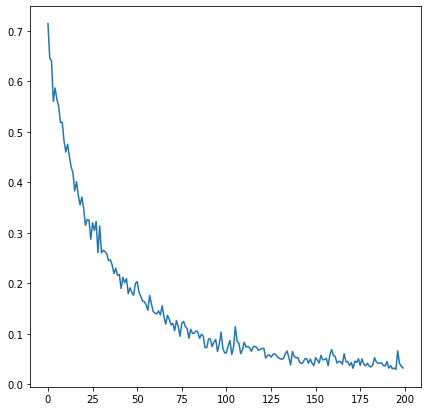

tensor(1.5725e-08)


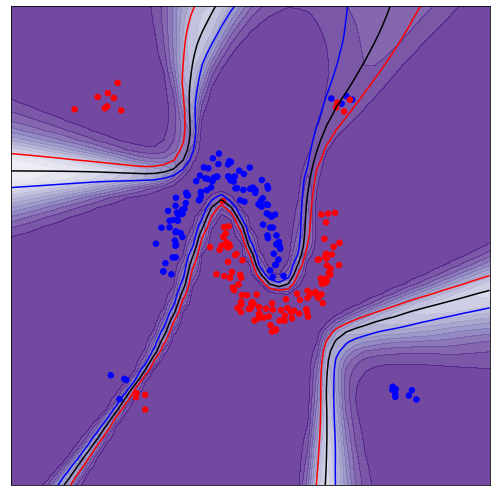

In [6]:
from model import resnet_dropout
from model import DropoutTabularResNet

net_params = dict(
    num_classes=2,
    in_features=2,
    mc_samples=1000,
    n_residual_layers=2,
    p_drop=0.5
)
epochs = 200
weight_decay = 0
method = "dir_variance"

for mode, ds in enumerate([train_ds, extend_ds]):
    torch.manual_seed(0)
    name = "" if mode == 0 else "_retrained"
    X_plot, y_plot = (X, y) if mode == 0 else (X_ext, y_ext)

    train_loader = torch.utils.data.DataLoader(ds, batch_size=128, shuffle=True)
    model_dropout = DropoutTabularResNet(**net_params)
    optimizer = torch.optim.Adam(model_dropout.parameters(), lr=1e-3, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    history = []
    for i in range(epochs):
        train_stats = resnet_dropout.train_one_epoch(model_dropout, train_loader, criterion, optimizer, epoch=i, device='cpu')
        history.append(train_stats)
    model_dropout.cpu()
    model_dropout.eval()

    plt.figure(figsize=figsize)
    plt.plot([d['train_loss'] for d in history])
    plt.show()

    name = "" if mode == 0 else "_retrained"
    domain = 5
    fig = plt.figure(figsize=figsize)
    plot_contour_sampling(model_dropout, X_plot, y_plot, method=method, levels=levels["mc_dropout"])
    fig.axes[0].get_xaxis().set_visible(False)
    fig.axes[0].get_yaxis().set_visible(False)
    fig.axes[0].get_xaxis().set_ticks([])
    fig.axes[0].get_yaxis().set_ticks([])
    plt.tight_layout()
    plt.savefig(plot_path/f'mc_dropout_2d{name}.pdf', bbox_inches='tight')
    plt.show()

    if mode == 0:
        weights = resnet_dropout.reweight(model_dropout, reweight_loader, device='cpu')
        fig = plt.figure(figsize=figsize)
        plot_contour_sampling(model_dropout, X_ext, y_ext, weights=weights, method=method, levels=levels["mc_dropout"])
        fig.axes[0].get_xaxis().set_visible(False)
        fig.axes[0].get_yaxis().set_visible(False)
        fig.axes[0].get_xaxis().set_ticks([])
        fig.axes[0].get_yaxis().set_ticks([])
        plt.tight_layout()
        plt.savefig(plot_path/'mc_dropout_2d_reweighted.pdf', bbox_inches='tight')
        plt.show()

## Ensembles

Epoch [0] Model [0]  [0/2] eta: 0:00:00 lr: 0.001 loss: 0.7012 (0.7012) acc1: 51.5625 (51.5625) time: 0.0090 data: 0.0026
Epoch [0] Model [0]  Total time: 0:00:00
Epoch [0] Model [1]  [0/2] eta: 0:00:00 lr: 0.001 loss: 0.9134 (0.9134) acc1: 50.0000 (50.0000) time: 0.0106 data: 0.0028
Epoch [0] Model [1]  Total time: 0:00:00
Epoch [0] Model [2]  [0/2] eta: 0:00:00 lr: 0.001 loss: 0.7012 (0.7012) acc1: 47.6562 (47.6562) time: 0.0088 data: 0.0025
Epoch [0] Model [2]  Total time: 0:00:00
Epoch [0] Model [3]  [0/2] eta: 0:00:00 lr: 0.001 loss: 0.8907 (0.8907) acc1: 15.6250 (15.6250) time: 0.0043 data: 0.0014
Epoch [0] Model [3]  Total time: 0:00:00
Epoch [0] Model [4]  [0/2] eta: 0:00:00 lr: 0.001 loss: 0.4819 (0.4819) acc1: 81.2500 (81.2500) time: 0.0046 data: 0.0016
Epoch [0] Model [4]  Total time: 0:00:00
Epoch [0] Model [5]  [0/2] eta: 0:00:00 lr: 0.001 loss: 0.7206 (0.7206) acc1: 52.3438 (52.3438) time: 0.0053 data: 0.0014
Epoch [0] Model [5]  Total time: 0:00:00
Epoch [0] Model [6]  [

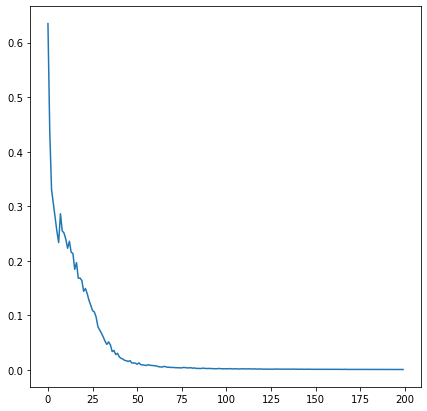

tensor(0.)


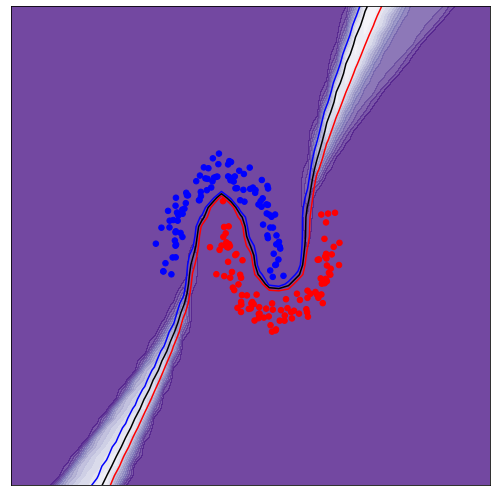

tensor(3.5527e-15)


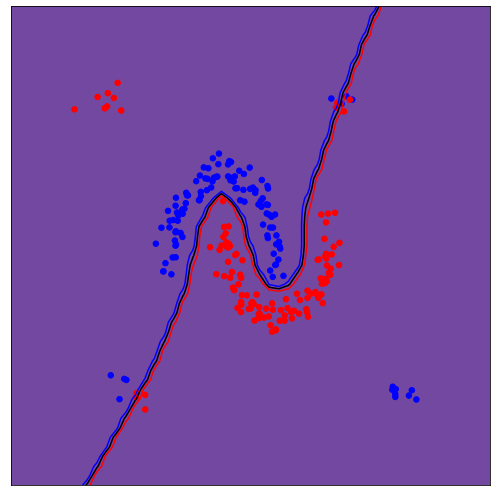

Epoch [0] Model [0]  [0/2] eta: 0:00:00 lr: 0.001 loss: 0.7526 (0.7526) acc1: 53.1250 (53.1250) time: 0.0064 data: 0.0015
Epoch [0] Model [0]  Total time: 0:00:00
Epoch [0] Model [1]  [0/2] eta: 0:00:00 lr: 0.001 loss: 0.8343 (0.8343) acc1: 52.3438 (52.3438) time: 0.0032 data: 0.0011
Epoch [0] Model [1]  Total time: 0:00:00
Epoch [0] Model [2]  [0/2] eta: 0:00:00 lr: 0.001 loss: 0.6815 (0.6815) acc1: 53.1250 (53.1250) time: 0.0032 data: 0.0011
Epoch [0] Model [2]  Total time: 0:00:00
Epoch [0] Model [3]  [0/2] eta: 0:00:00 lr: 0.001 loss: 0.8664 (0.8664) acc1: 21.0938 (21.0938) time: 0.0030 data: 0.0010
Epoch [0] Model [3]  Total time: 0:00:00
Epoch [0] Model [4]  [0/2] eta: 0:00:00 lr: 0.001 loss: 0.6275 (0.6275) acc1: 75.0000 (75.0000) time: 0.0029 data: 0.0010
Epoch [0] Model [4]  Total time: 0:00:00
Epoch [0] Model [5]  [0/2] eta: 0:00:00 lr: 0.001 loss: 0.7077 (0.7077) acc1: 53.9062 (53.9062) time: 0.0031 data: 0.0009
Epoch [0] Model [5]  Total time: 0:00:00
Epoch [0] Model [6]  [

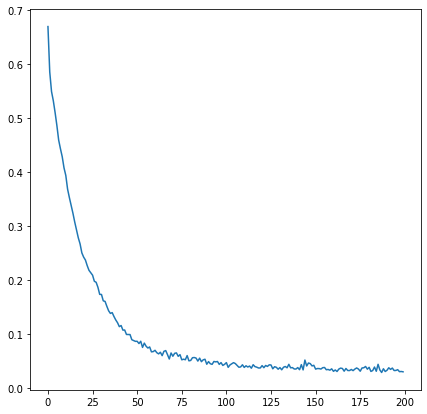

tensor(1.9323e-28)


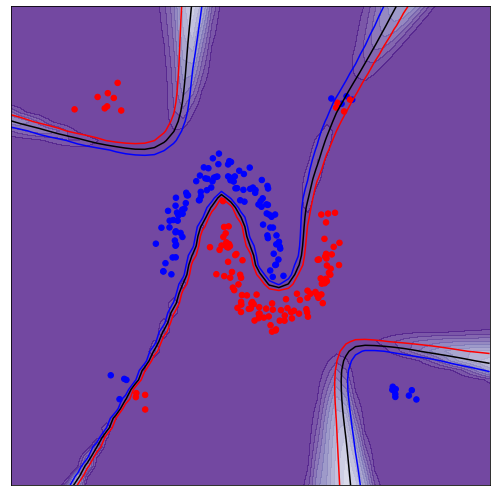

In [7]:
from model import ensemble
from model import TabularResNet

net_params = dict(
    num_classes=2,
    in_features=2,
    n_residual_layers=2,
)
epochs = 200
n_member = 20
weight_decay = 0
method = "dir_variance"

for mode, ds in enumerate([train_ds, extend_ds]):
    torch.manual_seed(0)
    name = "" if mode == 0 else "_retrained"
    X_plot, y_plot = (X, y) if mode == 0 else (X_ext, y_ext)

    train_loader = torch.utils.data.DataLoader(ds, batch_size=128, shuffle=True)

    model_ensemble = ensemble.Ensemble(models=[TabularResNet(**net_params) for i in range(n_member)])
    optimizer = ensemble.EnsembleOptimizer([
                torch.optim.Adam(
                    m.parameters(),
                    lr=1e-3,
                    weight_decay=weight_decay,
                )
                for m in model_ensemble
            ])
    criterion = nn.CrossEntropyLoss()
    history = []
    for i in range(epochs):
        train_stats = ensemble.train_one_epoch(model_ensemble, train_loader, criterion, optimizer, epoch=i, device='cpu')
        history.append(train_stats)
    model_ensemble.cpu()
    model_ensemble.eval()

    plt.figure(figsize=figsize)
    plt.plot([d['train_loss'] for d in history])
    plt.show()

    name = "" if mode == 0 else "_retrained"
    domain = 5
    fig = plt.figure(figsize=figsize)
    plot_contour_sampling(model_ensemble, X_plot, y_plot, method=method, levels=levels["ensemble"])
    fig.axes[0].get_xaxis().set_visible(False)
    fig.axes[0].get_yaxis().set_visible(False)
    fig.axes[0].get_xaxis().set_ticks([])
    fig.axes[0].get_yaxis().set_ticks([])
    plt.tight_layout()
    plt.savefig(plot_path/f'ensemble_2d{name}.pdf', bbox_inches='tight')
    plt.show()

    if mode == 0:
        weights = ensemble.reweight(model_ensemble, reweight_loader, device='cpu')
        fig = plt.figure(figsize=figsize)
        plot_contour_sampling(model_ensemble, X_ext, y_ext, weights=weights, method=method, levels=levels["ensemble"])
        fig.axes[0].get_xaxis().set_visible(False)
        fig.axes[0].get_yaxis().set_visible(False)
        fig.axes[0].get_xaxis().set_ticks([])
        fig.axes[0].get_yaxis().set_ticks([])
        plt.tight_layout()
        plt.savefig(plot_path/'ensemble_2d_reweighted.pdf', bbox_inches='tight')
        plt.show()